## CuriosiDados 1 - Quais cidades mais produziram laranja nos últimos 45 anos?

In [1]:
# Importando bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import basedosdados as bd
import geobr

### Avisos antes de continuar!

As próximas 6 células foram usadas apenas para baixar os dados utilizados, então não é necessário instalar a biblioteca `basedosdados` (caso queira, fique a vontade! ela é **MUITO** útil para conseguir dados) e nem rodas as próximas células.

A seção de <font color = 'blue'>Manipulação<font color = 'black'> tem um roteirinho a ser seguido. Ele não é longo, e muitas das coisas podem ser vistas em notebooks de aulas (caso não queira abrir os notebooks, eles estão todos no GitHub do grupo).

A seção de <font color = 'blue'>Visualização<font color = 'black'> já está feita, mas recomendo tentar entender o que as linhas do código mudaram na visualização, isso ajuda bastante a lembrar como fazer as alterações.

In [ ]:
# Baixando os dados de produção pela API da Base dos Dados
query_sp = """
        SELECT *
        FROM `basedosdados.br_ibge_pam.municipio_lavouras_permanentes`
        WHERE sigla_uf = 'SP'
        AND produto = 'Laranja'
        """

df = bd.read_sql(query_sp, billing_project_id = 'projeto1-311803')

In [ ]:
# Salvando os dados como um arquivo csv
df.to_csv('../prod_laranja_aqa/prod_laranja_sp.csv', index = False)

In [ ]:
bd.get_table_columns('br_bd_diretorios_brasil', 'municipio')

In [ ]:
# Baixando dados para liguar o id do município ao nome do município

query = """
        SELECT id_municipio, nome
        FROM `basedosdados.br_bd_diretorios_brasil.municipio`
        WHERE sigla_uf = 'SP'
"""

df_ids = bd.read_sql(query, billing_project_id = 'projeto1-311803')

In [ ]:
df_ids.head()

In [ ]:
df_ids.to_csv('../prod_laranja_aqa/relacao_id_nome.csv', index = False)

<br>

<br>

## Manipulação
---
Queremos encontrar os 10 municípios com maior produção de laranja ao longo da série (1974 - 2018).

In [3]:
# Leia o arquivo 'prod_laranja_sp.csv' e armazene em uma variável
df = pd.read_csv('prod_laranja_sp.csv')

### `.group_by()`

Agrupe a coluna `quantidade_produzida` por município e some as produções anuais e salvar em uma nova variável. A função deve retornar um objeto `pd.DataFrame` ao invés de um objeto `pd.Series`.

<font size = 2>caso tenho dúvidas, lembre que quando queremos selecionar mais de uma coluna de um dataframe, utilizamos uma a seguinte sintaxe: `df[['coluna1', 'coluna2']]`, isso porque quando queremos ler mais de uma coluna, precisamos passa-las no formato de lista (tente selecionar duas colunas com apenas um par de colchetes, irá gerar um erro). Lembre também que as colunas de um dataframe podem ser interpretadas como listas. Dessa forma, quando usamos a notação `df[['coluna1']]` a saída é uma lista de listas, que o pandas transforma em um dataframe.

In [4]:
df_agrupado = df.groupby('id_municipio')[['quantidade_produzida']].sum()

In [5]:
df_agrupado.head()

,quantidade_produzida
id_municipio,
3500105,207910.0
3500204,6223134.0
3500303,13174686.0
3500402,6140.0
3500501,47373.0


Transforme o índice do dataframa em uma coluna.

In [6]:
# .reset_index()
df_agrupado = df_agrupado.reset_index()

In [7]:
df_agrupado.head()

,id_municipio,quantidade_produzida
0,3500105,207910.0
1,3500204,6223134.0
2,3500303,13174686.0
3,3500402,6140.0
4,3500501,47373.0


### Ordenar

Ordene o dataframe pela coluna `quantidade_produzida` de forma decrescentea e armazene os **10 maiores** em uma nova variável

In [16]:
# .sort_values()
df_rank = df_agrupado.sort_values(by = 'quantidade_produzida', ascending = False).head(10)

In [17]:
df_rank

,id_municipio,quantidade_produzida
68,3506102,83752164.0
341,3530706,79968458.0
257,3522703,58787985.0
379,3533908,58046131.0
300,3526902,51232119.0
349,3531506,42437903.0
36,3503208,41358768.0
591,3553708,41273923.0
122,3510807,38798969.0
62,3505500,33807413.0


Agora que temos um dataframe contendo os 10 maiores produtores de laranja do estado, precimos da uma maneira de mapear os ids aos nomes dos municípios.

Leia o arquivo `relacao_id_nome.csv`.

In [18]:
df_ids = pd.read_csv('relacao_id_nome.csv')

In [19]:
df_ids.head()

,id_municipio,nome
0,3500105,Adamantina
1,3500204,Adolfo
2,3500303,Aguaí
3,3500402,Águas da Prata
4,3500501,Águas de Lindóia


### `.merge()`

A função `.merge()` funciona como o **PROCV** no excel. Com ela, nós podemos juntar duas tabelas por meio de uma coluna em comum.

No nosso caso, temos dois dataframes: um contendo o o id e a produção dos 10 maiores produtores de laranja do estado e outro com o id e nome dos municipios de São Paulo. Vamos usar a função `.merge()` para junta-las.

A função recebe 4 argumentos principais: `left`, `right`, `on` e `how`. Os dois primeiros indicam quais dataframes serão utilizados. Por convenção a tabela da esquerda é a tabela que queremos adicionar a coluna, enquanto a da direita é a que vai 'ceder' a coluna.

O argumento `on` indica qual coluna dos dataframes será utilizada como *link* (coluna em comum).

**OBS**: caso as colunas tenham nomes diferentes nos dataframes, devemos utilizar os argumentos `left_on` e `right_on` para indicar os nomes em cada dataframe.

Por último, o argumento `how` indica qual será o método utilizado para realizar a junção. Por padrão este argumento é `'inner'`, que indica que queremos trazer apenas as linhas da tabela da direita que tem correspondência na tabela da direita.

In [20]:
df_nomes = pd.merge(left = df_rank, right = df_ids, on = 'id_municipio', how = 'inner')

In [21]:
df_nomes.head()

,id_municipio,quantidade_produzida,nome
0,3506102,83752164.0,Bebedouro
1,3530706,79968458.0,Mogi Guaçu
2,3522703,58787985.0,Itápolis
3,3533908,58046131.0,Olímpia
4,3526902,51232119.0,Limeira


## Visualizações

### Ranking

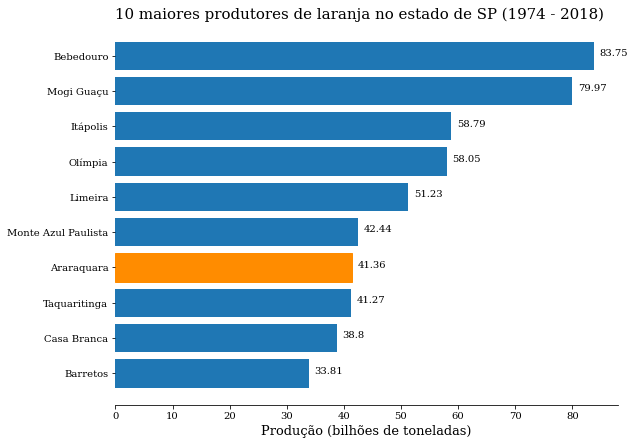

In [22]:
# Definindo o padrão das fontes
plt.rcParams["font.family"] = 'serif'

# Criando objetos da figura e eixo
fig, ax = plt.subplots(figsize = (9,7))

# Plotando
barras = ax.barh(y = df_nomes.index, width = df_nomes['quantidade_produzida'], color = '#1F77B4')
ax.invert_yaxis()

# Título
ax.set_title('10 maiores produtores de laranja no estado de SP (1974 - 2018)', fontsize = 15, loc = 'left')

# Eixo y
ax.set_yticks(np.arange(0,10))
ax.set_yticklabels(df_nomes['nome'])

# Eixo x
xtick_labels = np.arange(0, 90, step = 10)
ax.set_xticklabels(xtick_labels)
ax.set_xlabel('Produção (bilhões de toneladas)', fontsize = 13)

# Spines
spines = ['left', 'right', 'top']
for spine in spines:
    ax.spines[spine].set_visible(False)
    
# Valor da produção na frente da barra
for barra in barras:
    largura = barra.get_width()
    ax.text(x = largura + 1000000, y = barra.get_y() + barra.get_height()/2, s = round(largura / 1000000, 2))
    
# Coluna Araraquara
barras[6].set_color('darkorange')

plt.show()

In [27]:
fig.savefig('ranking_cidades.jpg', edgecolor='none', bbox_inches = 'tight', facecolor = fig.get_facecolor())